In [1]:
import datasets
import json

import os
import pandas as pd

In [2]:
%env HF_HOME ~/hf_datasets

env: HF_HOME=~/hf_datasets


In [3]:
ds_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/web_internal_dc_2025-06-12/hf_dataset/'

# 4fps rotated
ds_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-experiments/pipeline_data/main/lr_eval_single_model/20250703-071904/filter_fps/web_internal_dc_2025-06-12_4fps/hf_dataset/'

output_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/hackathon_2025-07_camera_fingerprint/'

In [4]:
%%time
ds = datasets.load_from_disk(ds_uri)

CPU times: user 3.96 s, sys: 3.49 s, total: 7.45 s
Wall time: 10.5 s


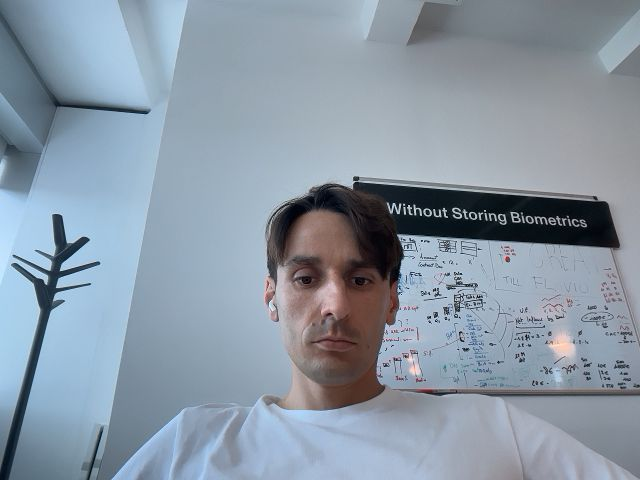

In [5]:
ds[0]["img_raw"]

In [6]:
len(ds)

64823

## Add device info

In [7]:
test_users = ['ahmed.atef@keyless.io', 'milan.sekulic@keyless.io', 'douglas.fairchild@keyless.io', 'jacopo.barto@keyless.io', 'vojtech.orgon@keyless.io', 'dario@keyless.io']


In [8]:


def process_row(row):
    dm = json.loads(row['device_metadata'])
    row["camera_label"] = dm.get('media', {}).get('device', {}).get('info', {}).get('label')
    row["camera_device_id"] = dm.get('media', {}).get('device', {}).get('info', {}).get('deviceId')

    row["user_agent"] = dm.get('navigator', {}).get('userAgent')

    parsed_ua = dm.get('navigator', {}).get('userAgentParsed', {})
    row["browser_name"] = parsed_ua.get('browser', {}).get('name')
    row["device_model"] = parsed_ua.get('device', {}).get('model')
    row["device_vendor"] = parsed_ua.get('device', {}).get('vendor')
    row["os_name"] = parsed_ua.get('os', {}).get('name')
    row["os_version"] = parsed_ua.get('os', {}).get('version')
    row["user_device_camera"] = f'{row["subject_name"]}___{row["camera_device_id"]}'

    #if row["os_name"].lower() == 'ios':
    #    row["img_raw"] = row["img_raw"].rotate(270)

    row["split"] = "test" if row["subject_name"] in test_users else "train"
    row["img_w"] = row["img_raw"].width
    row["img_h"] = row["img_raw"].height
    row["img_wh"] = f'{row["img_w"]}x{row["img_h"]}'
    return row


d = json.loads(ds[0]['device_metadata'])
d.get('media', {}).get('device', {}).get('info', {}).get('label')


'MacBook Air Camera (0000:0001)'

In [9]:
ds = ds.map(process_row, num_proc=os.cpu_count()-1)

Map (num_proc=63):   0%|          | 0/64823 [00:00<?, ? examples/s]

## Analysis

In [10]:
%%time
df = ds.to_pandas()
print(df.shape)
df.head(3)

(64823, 65)
CPU times: user 705 ms, sys: 1.03 s, total: 1.74 s
Wall time: 1.71 s


,img_raw,photo_name,subject_name,session_folder,dataset_name,is_genuine_attempt,is_spoof,attack_type,datacollection_start_timestamp_s,attack_filename,...,browser_name,device_model,device_vendor,os_name,os_version,user_device_camera,split,img_w,img_h,img_wh
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480


In [11]:
print(f'unique users: {len(set(df.subject_name))}')
print(f'unique sessions: {len(set(df.session_folder))}')
print(f'unique camera labels: {len(set(df.camera_label))}')
print(f'unique camera device ids: {len(set(df.camera_device_id))}')
print(f'unique camera user devices: {len(set(df.user_device_camera))}')


unique users: 52
unique sessions: 1890
unique camera labels: 50
unique camera device ids: 163
unique camera user devices: 169


In [12]:
(df
    .groupby('subject_name')
    .agg({'session_folder': 'nunique', 'photo_name': 'nunique', 'camera_device_id': 'nunique'})
    .sort_values(by=['session_folder', 'photo_name'], ascending=False)
)

,session_folder,photo_name,camera_device_id
subject_name,,,
flavio@keyless.io,380,9415,15
ahmed.atef@keyless.io,265,10214,7
iryna.kozoriz@keyless.io,187,6975,21
michele@keyless.io,112,3264,2
lukas@keyless.io,85,2730,3
mattia.vighesso@keyless.io,72,2622,6
paolo@keyless.io,63,2520,4
daniele@keyless.io,61,2241,2
francesca.mavilio@keyless.io,52,1933,3


## Dataset splits

In [13]:
important_columns = [
    'subject_name', 'session_folder', 'photo_name', # user / session / frame ids
    'gif_link', 'file_timestamp_within_session_ms', 'frame_number', # frame info
    'device_metadata', # json string with all the device metadata info
    'camera_device_id', 'camera_label', 'user_device_camera', # camera info parsed from device metadata
    'os_name', 'os_version', # os info
    'img_w', 'img_h', 'img_wh', # img info

]

In [14]:
df[important_columns].head(3)

,subject_name,session_folder,photo_name,gif_link,file_timestamp_within_session_ms,frame_number,device_metadata,camera_device_id,camera_label,user_device_camera,os_name,os_version,img_w,img_h,img_wh
0,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,0.0,0.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,macOS,10.15.7,640,480,640x480
1,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,299.0,6.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,macOS,10.15.7,640,480,640x480
2,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,599.0,12.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,macOS,10.15.7,640,480,640x480


In [16]:
%%time
ds.save_to_disk(output_uri)
print(f'saved to "{output_uri}"')

Saving the dataset (0/5 shards):   0%|          | 0/64823 [00:00<?, ? examples/s]

saved to "s3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/hackathon_2025-07_camera_fingerprint/"
CPU times: user 9.21 s, sys: 4.34 s, total: 13.5 s
Wall time: 32.5 s
